# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Streaming Processing** </center>
---

**Date**: October, 2025

**Student Name**: Luis Angel Santana Hernandez

**Professor**: Pablo Camarillo Ramirez

#### NOTES


localhost:8888 #junyper
1. open a terminal
2. install terminals

>pip install kafka-python

>pip install faker

3. console create topic

>docker exec -it fbc2a54c885b /opt/kafka/bin/kafka-topics.sh --create --zookeeper zookeeper:2181 --replication-factor 1 --partitions 1 --topic topic-videogame-proyect

4. in junyper terminal

>python3 game_telemetry_kafka_topic.py kafka:9093 topic-videogame-proyect


# Create SparkSession

In [11]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (Kafka)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

# Create a data stream from a Kafka topic

In [12]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "topic-videogame-proyect") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [13]:
from pyspark.sql.functions import year, month, day, from_json, col
from pyspark.sql.types import StructField, StringType
from luis_santana.spark_utils import SparkUtils
from pyspark.sql.functions import  col, when,avg,sum,count, struct, split,max

vg_telemetry_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

# We need to extract the columns from the input JSON

schema_metrics = SparkUtils.generate_schema([("xp_gained", "int"),
                                            ("deaths", "int"),
                                            ("kills", "int"),
                                            ("score", "int"),
                                            ("achievements_unlocked", "int")])
schema_performance = SparkUtils.generate_schema([
    ("avg_fps", "float"),
    ("avg_latency_ms", "int"),
    ("disconnects", "int")
])
schema_columns =[
    ("session_id", "string"),
    ("player_id", "string"),
    ("start_time", "timestamp"),
    ("end_time", "timestamp"),
    ("platform", "string"),
    ("game_version", "string"),
    ("player_level", "int"),
    ("country", "string")
]
pkg_schema = SparkUtils.generate_schema(schema_columns)
pkg_schema = pkg_schema.add(StructField("gameplay_metrics", schema_metrics))
pkg_schema = pkg_schema.add(StructField("performance_metrics", schema_performance))


vg_extracted_df = vg_telemetry_df.withColumn("telemetry", from_json(vg_telemetry_df.value_str, pkg_schema))

vg_extracted_df.printSchema()                                        

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- session_id: string (nullable = true)
 |    |-- player_id: string (nullable = true)
 |    |-- start_time: timestamp (nullable = true)
 |    |-- end_time: timestamp (nullable = true)
 |    |-- platform: string (nullable = true)
 |    |-- game_version: string (nullable = true)
 |    |-- player_level: integer (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- gameplay_metrics: struct (nullable = true)
 |    |    |-- xp_gained: integer (nullable = true)
 |    |    |-- deaths: integer (nullable = true)
 |    |    |-- kills: integer (nullable = true)
 |    |    |-- score: integer (nullable = true)
 |    |    |-- achievements_unlocked: integer (nullable = true)
 |    |-- performance_metrics: struct (nullable = true)
 |    |    |-- avg_fps: float (nullable = true)
 |    |    |-- avg_latency_ms: integer (nullable = true)
 |    |    |-- disconnects: integer (nullable = true)



## Tranformation 1: Player Engagement Analysis

In [14]:
ve_engagement_df = (
    vg_extracted_df
    .withColumn(
        "session_duration_minutes",
        (col("telemetry.end_time").cast("long") - col("telemetry.start_time").cast("long")) / 60
    )
    .withColumn(
        "kill_death_ratio",
        when(col('telemetry.gameplay_metrics.deaths') > 0,
            col("telemetry.gameplay_metrics.kills") / col("telemetry.gameplay_metrics.deaths"))
        .otherwise(col("telemetry.gameplay_metrics.kills"))
    )
    .withColumn(
        "xp_per_hour",
        col("telemetry.gameplay_metrics.xp_gained") / (col("session_duration_minutes") / 60)
    )
    .withColumn(
        "engagement_level",
        (col("telemetry.gameplay_metrics.xp_gained") * 0.3
         + col("session_duration_minutes")) * 0.35
        + col("telemetry.gameplay_metrics.kills") * 0.35
    )
)

## Transformation 2: Date time recived

In [15]:
vg_extracted_time_df = ve_engagement_df.withColumn("year", year(ve_engagement_df.telemetry.end_time)) \
                                      .withColumn("month", month(ve_engagement_df.telemetry.end_time)) \
                                      .withColumn("day", day(ve_engagement_df.telemetry.end_time))

vg_extracted_time_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- session_id: string (nullable = true)
 |    |-- player_id: string (nullable = true)
 |    |-- start_time: timestamp (nullable = true)
 |    |-- end_time: timestamp (nullable = true)
 |    |-- platform: string (nullable = true)
 |    |-- game_version: string (nullable = true)
 |    |-- player_level: integer (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- gameplay_metrics: struct (nullable = true)
 |    |    |-- xp_gained: integer (nullable = true)
 |    |    |-- deaths: integer (nullable = true)
 |    |    |-- kills: integer (nullable = true)
 |    |    |-- score: integer (nullable = true)
 |    |    |-- achievements_unlocked: integer (nullable = true)
 |    |-- performance_metrics: struct (nullable = true)
 |    |    |-- avg_fps: float (nullable = true)
 |    |    |-- avg_latency_ms: integer (nullable = true)
 |    |    |-- disconnects: integer (nullable = true)
 |-- 

## Transformation 3: Console

Spark no deja usar elementros dentro de struct fiels para particion pero yo quiero particionar por consola (partition.plataform)

In [16]:
vg_final_df = vg_extracted_time_df.withColumn("platform", col("telemetry.platform"))
vg_final_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- session_id: string (nullable = true)
 |    |-- player_id: string (nullable = true)
 |    |-- start_time: timestamp (nullable = true)
 |    |-- end_time: timestamp (nullable = true)
 |    |-- platform: string (nullable = true)
 |    |-- game_version: string (nullable = true)
 |    |-- player_level: integer (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- gameplay_metrics: struct (nullable = true)
 |    |    |-- xp_gained: integer (nullable = true)
 |    |    |-- deaths: integer (nullable = true)
 |    |    |-- kills: integer (nullable = true)
 |    |    |-- score: integer (nullable = true)
 |    |    |-- achievements_unlocked: integer (nullable = true)
 |    |-- performance_metrics: struct (nullable = true)
 |    |    |-- avg_fps: float (nullable = true)
 |    |    |-- avg_latency_ms: integer (nullable = true)
 |    |    |-- disconnects: integer (nullable = true)
 |-- 

## Persistence Data

In [17]:
query_files = vg_final_df.writeStream \
                .trigger(processingTime="10 seconds") \
                .partitionBy("year","month","platform") \
                .format("parquet") \
                .option("header", "true") \
                .option("path", "/opt/spark/work-dir/data/Proyect/Streaming") \
                .option("checkpointLocation", "/opt/spark/work-dir/data/Proyect/Streaming_checkPoint") \
                .start()

25/11/16 19:45:42 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [18]:
!ls /opt/spark/work-dir/data/Proyect/Streaming

_spark_metadata


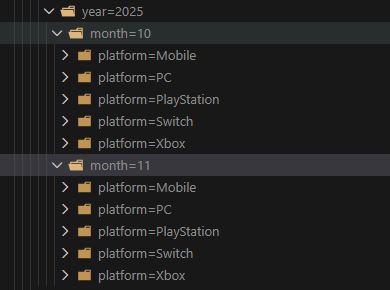

# POWER BI

1. Folder> select proyect > Transform Data

2. Choose Columes > select Content Extension > Folder Path

3. Extension> Filter> .parquet

4. Folder Path > formula > 

``` = Table.TransformColumns(#"Filtered Rows", {
    {"Folder Path", each Text.Middle(_, Text.PositionOf(_, "year=")) }
}) ```

Folder path > Home > Slit Colum > Delimiter

transform > Estract > Text After Delimiter > use /

change names

for each: Transform > Estract > After Delimiter > "=" 

for each: Transform > Detect Data Type

presionar a Content y en las dos flechas para extraer datos

genera muchos pasos (elimina el de "Removed Other Colums")

presionar a Content y en las dos flechas para extraer datos

repite para todos "Record"

vuelve a elegir las columnas que quieres

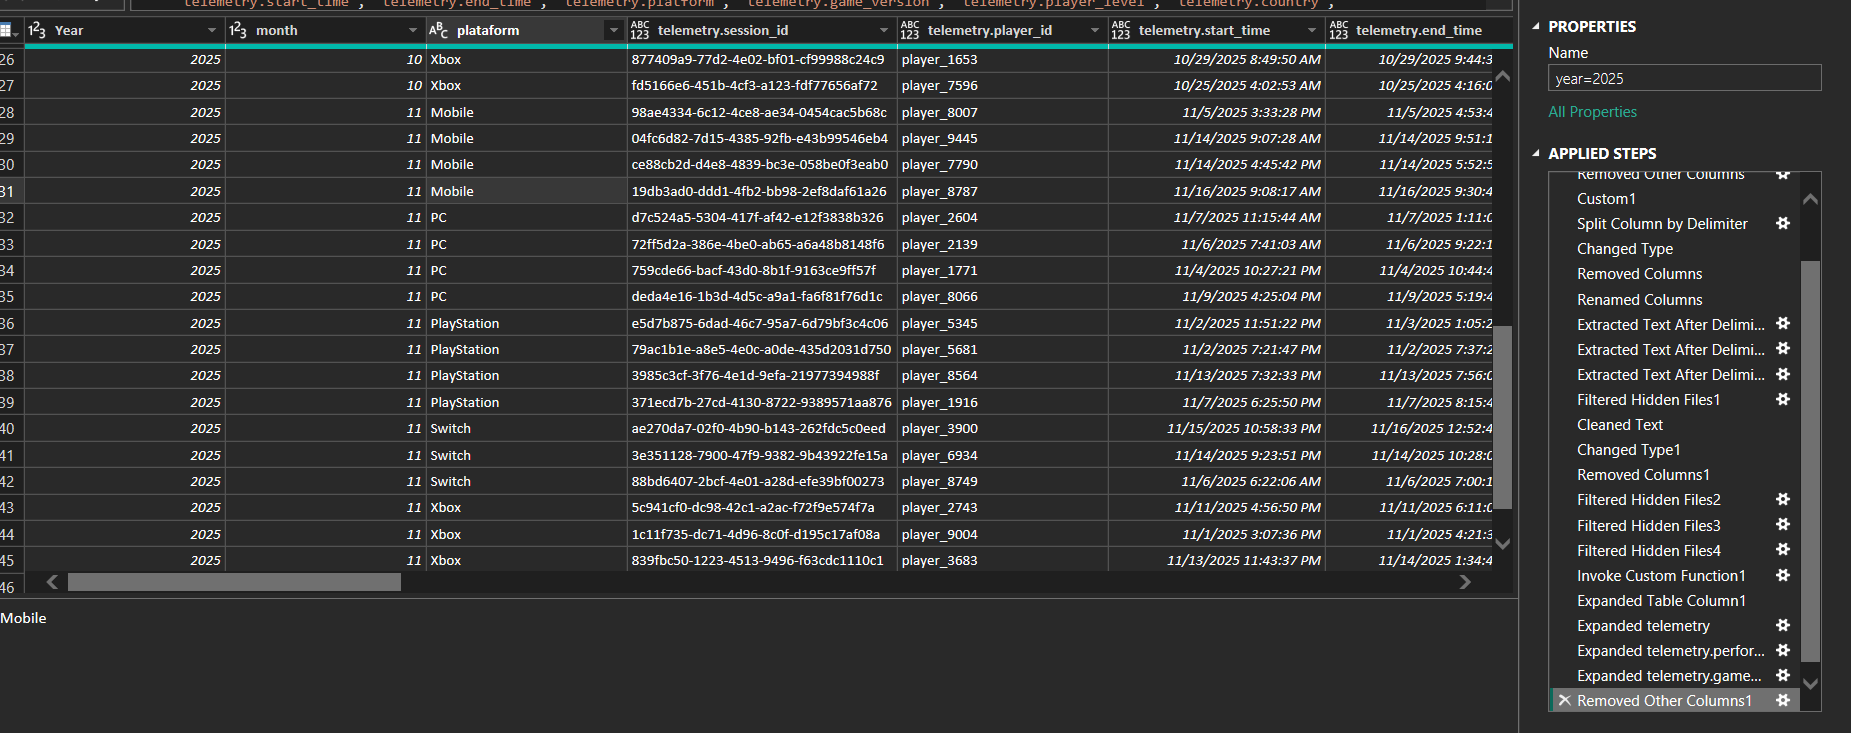

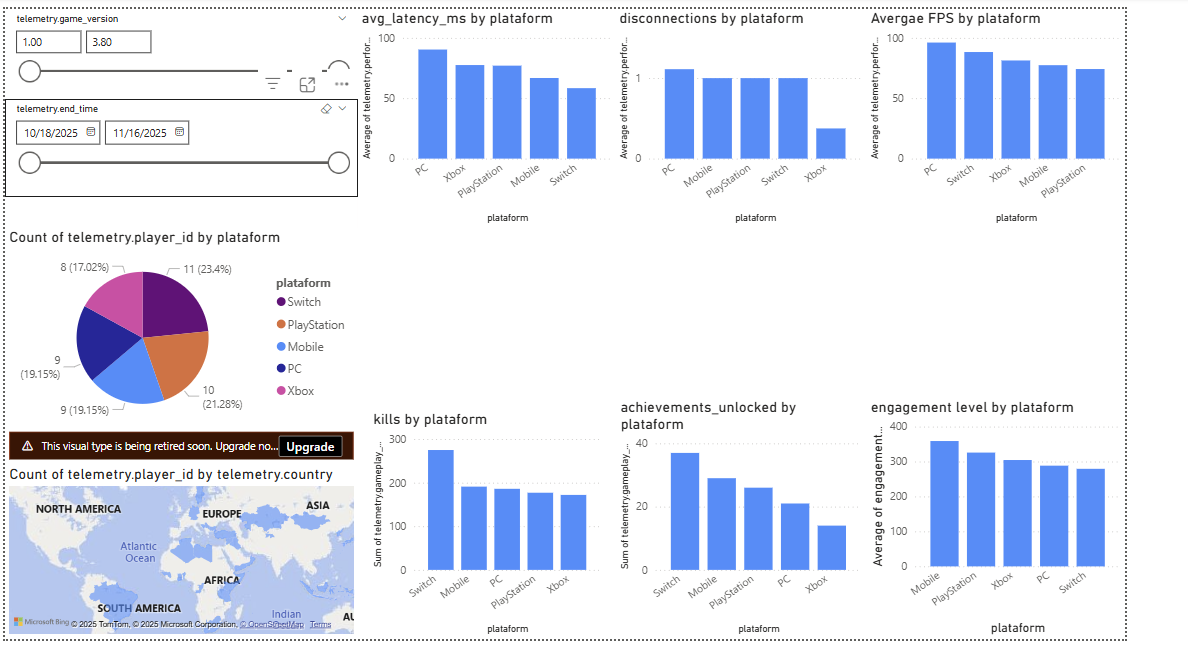

/\ Server performance metrics

|   |

\\/ User stats metrics

In [20]:
sc.stop()

25/11/16 19:49:51 ERROR MicroBatchExecution: Query [id = f900fcf0-538d-4443-80ac-10be4b44e958, runId = f20d57b4-af32-4d2e-a808-ae32c50c0d8e] terminated with error
java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:627)
	at scala.None$.get(Option.scala:626)
	at org.apache.spark.sql.execution.datasources.BasicWriteJobStatsTracker$.metrics(BasicWriteStatsTracker.scala:240)
	at org.apache.spark.sql.execution.streaming.FileStreamSink.basicWriteJobStatsTracker(FileStreamSink.scala:148)
	at org.apache.spark.sql.execution.streaming.FileStreamSink.addBatch(FileStreamSink.scala:185)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.$anonfun$runBatch$17(MicroBatchExecution.scala:879)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$